In [15]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pckgs.headline_preprocess import HeadlinePreprocess
from pckgs.helper import timeseries_to_supervised2
from pckgs.models import get_model_price, train_model, get_model_both_sent, get_model_both_emb
from pckgs.price_preprocess import PricePreprocess
from sklearn.model_selection import train_test_split
from pckgs.evaluator import Evaluator
import numpy as np
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 400

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
coins = {}
coin_names = ['BTC_USD', 'ETH_USD', 'XRP_USD', 'LTC_USD', 'BCH_USD', 'LINK_USD']
coin_dirs = []
for i in range(len(coin_names)): coin_dirs.append('./datasets/coinbase_hour_candles/' + coin_names[i] + '.feather')
coins = {coin_names[i]:coin_dirs[i] for i in range(len(coin_names))}
coins


problem = 'p'
# problem = 'pp'
# problem = 'pe'

start_date = ''
end_date = ''

lag = 21
# threshold = 0.0025
threshold = 0.1
pp = PricePreprocess(lag, threshold)

{'BTC_USD': './datasets/coinbase_hour_candles/BTC_USD.feather',
 'ETH_USD': './datasets/coinbase_hour_candles/ETH_USD.feather',
 'XRP_USD': './datasets/coinbase_hour_candles/XRP_USD.feather',
 'LTC_USD': './datasets/coinbase_hour_candles/LTC_USD.feather',
 'BCH_USD': './datasets/coinbase_hour_candles/BCH_USD.feather',
 'LINK_USD': './datasets/coinbase_hour_candles/LINK_USD.feather'}

<AxesSubplot:xlabel='time'>

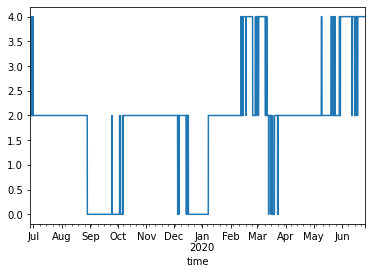

In [22]:
##one coin
candle = pd.read_feather(coins['LINK_USD'])
candle.set_index('time', inplace=True)
candle.index = candle.index.tz_localize(None)

positions = pp.preprocess(candle)
# positions


y = positions.loc[:, ['down', 'same', 'up']]
if problem == 'p':
    x = positions.drop(['down', 'same', 'up'], axis=1)
elif problem =='pp':
    x = positions.drop(['down', 'same', 'up'], axis=1)
    sentiment = pd.read_csv('../Text/datasets/headline_sentiment_mean.csv', index_col='date', parse_dates=['date'])
    sentiment_score = timeseries_to_supervised2(sentiment, lag=21)
    sentiment_score.dropna(inplace=True)
    sentiment_score.drop('sentiment_score_t', axis=1, inplace=True)
    x2 = sentiment_score
    x = x2.merge(x, left_index=True, right_on=pd.to_datetime(x.index.strftime('%Y-%m-%d')), how='right').dropna()
    x.drop(columns='key_0', inplace=True)
    x = x.values.reshape((len(x), int(len(x.columns) / 2), 2), order='F')
# elif problem =='pe':
    # x = positions.drop(['down', 'same', 'up'], axis=1)
    # headline = pd.read_csv('../Text/datasets/headline_embeddings_mean.csv', index_col='date', parse_dates=['date'])
    # x2 = HeadlinePreprocess.shape_vectors(headline, lag, y.index)


if problem == 'p' or problem =='pp':
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
# elif problem == 'pe':
#     x1_train, x1_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
#     x2_train, x2_test, _, _ = train_test_split(x2, y, test_size=0.2, shuffle=False)
#     del _
#     x_train = [x1_train, x2_train]
#     x_test = [x1_test, x2_test]



if problem == 'p':
    model = get_model_price()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_price.h5', epochs=2)
elif problem =='pp':
    model = get_model_both_sent()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_both_sent.h5', epochs=2)
# elif problem =='pe':
#     model = get_model_both_emb()
#     model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_both_sent.h5', epochs=2)


ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

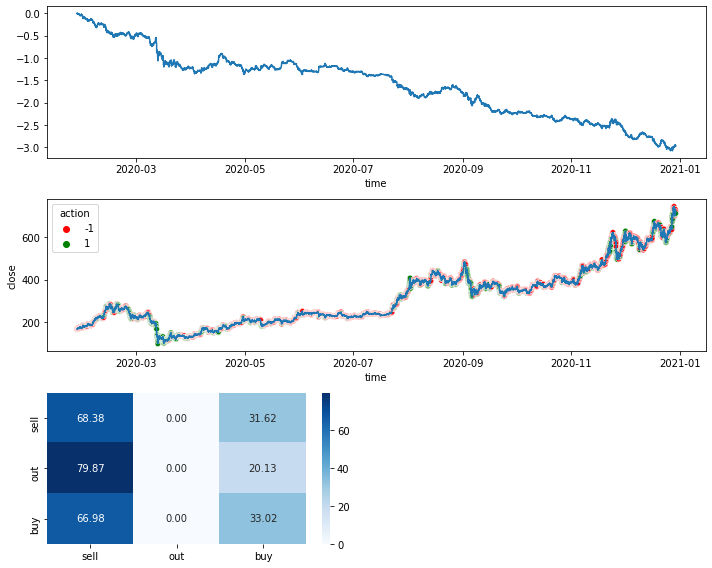

              precision    recall  f1-score   support

          -1       0.40      0.68      0.51      3324
           0       0.00      0.00      0.00      1197
           1       0.48      0.33      0.39      3571

    accuracy                           0.43      8092
   macro avg       0.29      0.34      0.30      8092
weighted avg       0.38      0.43      0.38      8092



/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:

test_index = y_test.index
train_index = y_train.index


#create labeled y_test to measure pnl, confusion matrix
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)


test_candle = candle.reindex(test_index)
train_candle = candle.reindex(train_index)

#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=test_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

Evaluator.evaluate(y_pred_labeled, y_test_labeled, test_candle)
print(classification_report(y_test_labeled, y_pred_labeled))

In [6]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=train_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, train_candle)
print(classification_report(y_train_labeled, y_predt_labeled))

                        0_t-1     1_t-1     2_t-1     3_t-1     4_t-1  \
time                                                                    
2016-05-18 22:00:00  0.059251 -0.060528  0.221884  0.214606  0.119504   
2016-05-18 23:00:00  0.059251 -0.060528  0.221884  0.214606  0.119504   
2016-05-19 00:00:00 -0.059913 -0.012410  0.014516 -0.329916 -0.156510   
2016-05-19 01:00:00 -0.059913 -0.012410  0.014516 -0.329916 -0.156510   
2016-05-19 02:00:00 -0.059913 -0.012410  0.014516 -0.329916 -0.156510   

                        5_t-1     6_t-1     7_t-1     8_t-1     9_t-1  ...  \
time                                                                   ...   
2016-05-18 22:00:00 -0.012858  0.205291  0.110251  0.574956  0.081143  ...   
2016-05-18 23:00:00 -0.012858  0.205291  0.110251  0.574956  0.081143  ...   
2016-05-19 00:00:00  0.112402 -0.021958 -0.212159  0.160066  0.158078  ...   
2016-05-19 01:00:00  0.112402 -0.021958 -0.212159  0.160066  0.158078  ...   
2016-05-19 02:00:00 